In [1]:
import torch.onnx
import torchvision
import torch
import numpy as np
from torch.autograd import Variable
from model_thermal_rgb import Discriminator, Generator
from config import Config
from thermal_dataset import ThermalImageDataset as ImageDataset
from thermal_dataset import calc_temp
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import scipy.misc
from torchvision.utils import save_image
import torch.nn.functional as F

/data/heesup/miniconda3/envs/thermalSR/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def add_colorbar(im,ax):
    # OFF AXX
    ax.axis("off")

    colorbar = plt.colorbar(im, ax=ax)
    # # Adjust the size and position of the colorbar
    pad = 0.005  # Distance between the image and colorbar
    width = 0.1 # Width of the colorbar
    # colorbar.ax.set_aspect(30)  # Adjust the aspect ratio of the colorbar
    colorbar.ax.set_position([ax.get_position().x1 + pad, ax.get_position().y0, width, ax.get_position().height])

    # Adjust the thickness of the gray bar
    #colorbar.ax.tick_params(width=2)  # Increase the linewidth of the tick marks
    #colorbar.outline.set_linewidth(2)  # Increase the linewidth of the colorbar outline

def move_image(input, x,y, border=cv2.BORDER_CONSTANT):
    pad_x = abs(x)
    pad_y = abs(y)
    shape = input.shape
    if len(shape) == 3:
        # Permute
        output = input.transpose(1,2,0)
        shape = output.shape
        output = cv2.copyMakeBorder(output, pad_y, pad_y, pad_x, pad_x, border)
        output = output[pad_y+y:pad_y+y+shape[0], pad_x+x:pad_x+x+shape[1],:]
        output = output.transpose(2,0,1)

    else:
        output = cv2.copyMakeBorder(input, pad_y, pad_y, pad_x, pad_x, border)
        output = output[pad_y+y:pad_y+y+shape[0], pad_x+x:pad_x+x+shape[1]]

    return output

def move_tensor(input, x,y, border=cv2.BORDER_CONSTANT):
    orig_shape = input.shape
    np_image = input.squeeze().numpy()
    temp = move_image(np_image,x,y,border=border)

    return torch.FloatTensor(temp.reshape(orig_shape))

@torch.no_grad()
def matchTemplateTorch(img, template):
    img_tensor = torch.from_numpy(img).unsqueeze(dim=0).unsqueeze(dim=0).type(torch.float32).cuda()
    template_tensor = torch.from_numpy(template).unsqueeze(dim=0).unsqueeze(dim=0).type(torch.float32).cuda()
    result = matchTemplateTorchCore(img_tensor, template_tensor)
    return result.cpu().numpy()

@torch.jit.script    
def matchTemplateTorchCore(img_tensor, template_tensor):
    result1 = torch.nn.functional.conv2d(img_tensor, template_tensor, bias=None, stride=1, padding=0)
    result2 = torch.sqrt(torch.sum(template_tensor**2) * torch.nn.functional.conv2d(img_tensor**2, torch.ones_like(template_tensor), bias=None, stride=1, padding=0))

    return (result1/result2).squeeze(0).squeeze(0)
    #return (result1).squeeze(0).squeeze(0)
   
def matchTemplateThetaBatch(background, template):
    batch_size = background.shape[0]
    theta = torch.zeros(batch_size, 6).to(background.device)

    for i in range(batch_size):
        template_i = template[i].unsqueeze(0)
        # Stretch template from 0 to 1
        template_i = (template_i - torch.min(template_i)) / (torch.max(template_i) - torch.min(template_i))
        
        background_i = F.interpolate(background[i].unsqueeze(0), size=(template_i.shape[-2], template_i.shape[-1]), mode='bilinear', align_corners=False)
        # Add padding to low img
        x_offset = background.shape[-2] // 4
        y_offset = background.shape[-1] // 4
        background_i = F.pad(background_i, (x_offset, x_offset, y_offset, y_offset), mode='replicate')
        res = matchTemplateTorchCore(background_i, template_i)
        result_max = torch.max(res)
        result_max_loc = torch.argmax(res)
        result_max_loc_x = result_max_loc % res.shape[0] 
        result_max_loc_y = result_max_loc // res.shape[1] 
        # print(result_max_loc_x, result_max_loc_y)

        # Make theta matrix from max location
        theta[i] = torch.tensor([1., 0., -2*(result_max_loc_x-x_offset)/ template.shape[-2], 0., 1., -2*(result_max_loc_y-y_offset) / template_i.shape[-1]])
        theta[i] = theta[i].unsqueeze(0).repeat(background_i.shape[0],1,1)

    return theta

In [3]:
config = Config()
# config.device = torch.device("cpu", 0)
model = Generator(debug=True)
#model.load_state_dict(torch.load('results/2022-05-01-ThermalRGB_NCCLoss_Fixbug/g-best.pth')) 
#model.load_state_dict(torch.load('results/2022-05-01-ThermalRGB_NCCLoss_Fixbug/g-last.pth')) # Best visual reslt
#model.load_state_dict(torch.load('results/2023-06-01-ThermalRGB_HRMSE_RGBNCC_RealTemp/g-last.pth'))
#model.load_state_dict(torch.load('results/2023-06-01-ThermalRGB_HRMSE_RGBNCC_RealTemp/g-last.pth'))
# model.load_state_dict(torch.load('results/2023-06-02-ThermalRGB_HRMSE_HRNCC_RealTemp/g-best.pth'))
#model.load_state_dict(torch.load('results/2023-06-06-ThermalRGB_HRMSE_HRNCC_T4Data/g_epoch_1301.pth')) # New structure!
# model.load_state_dict(torch.load('results/2023-06-07-ThermalRGB_HRMSE_HRNCC_TIGAN/g-best.pth'))
#model.load_state_dict(torch.load('results/2023-06-10-DeformableConv/g-last.pth'))
model.load_state_dict(torch.load('results/2023-06-11-CycleGANSR2/g-last.pth'))
model.to(config.device)
model.eval()

Generator(
  (conv_block1_ir): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (conv_block1_cycleGAN): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (conv_block1_rgb): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (rgb2ir): ResnetGenerator(
    (model): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 256, kernel_size=(3, 3), strid

{'lr': [42.04504347826089, 53.948630434782615], 'hr': [43.97000000000003, 51.505304347826105]}
tensor([[ 1.0000,  0.0000, -0.0469,  0.0000,  1.0000,  0.5000]])


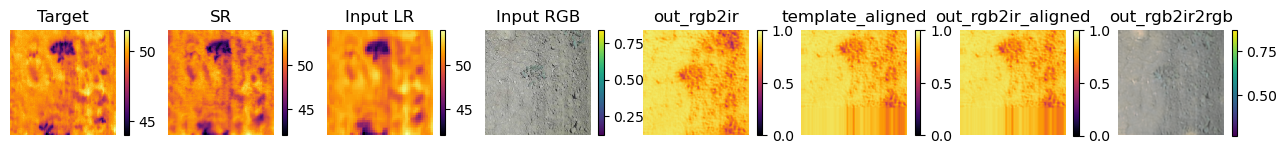

In [17]:
# Test Image
#sample_dataset = ImageDataset(dataroot="/home/lion397/data/datasets/GEMINI/Training_220315/val/",image_size=96, upscale_factor=4, mode="train")
#sample_dataset = ImageDataset(dataroot="/home/lion397/data/datasets/GEMINI/Training_220315/val",image_size=256, upscale_factor=4, mode="val")
#sample_dataset = ImageDataset(dataroot="/home/GEMINI/Dataset_processing/Davis_Legumes/2022-06-20/Thermal_Matched",image_size=96, upscale_factor=4, mode="val", random_crop=True)  
sample_dataset = ImageDataset(dataroot="/home/lion397/data/datasets/GEMINI/Training_T4_1_2_3/val",image_size=256, upscale_factor=4, mode="val", random_crop=True)  
(low_img, rgb_img, high_ir, thermal_info) = sample_dataset[100] # 늘 쓰던 Referene image
#rgb_img = move_tensor(rgb_img,0,20)
#rgb_img = torch.FloatTensor(np.zeros((3,256,256)))
high_img = high_ir.squeeze()
lr_img = low_img.squeeze()
lr = low_img.unsqueeze(0).to(config.device, non_blocking=True)
rgb = rgb_img.unsqueeze(0).to(config.device, non_blocking=True)
rgb_img_disp = rgb_img.permute(1,2,0).cpu().detach().numpy()
print(thermal_info)
sr, debug = model(lr, rgb)
# print(model.stn.dtheta)
sr_img = sr.squeeze().cpu().detach().numpy()
lr_img = lr.squeeze().cpu().detach().numpy()
high_img = high_ir.squeeze().cpu().detach().numpy()
f, axarr = plt.subplots(1,8, figsize=(16,8))
high_img = calc_temp(high_img, thermal_info['hr'])
im0 = axarr[0].imshow(high_img, interpolation='none', cmap='inferno')
axarr[0].set_title("Target")
add_colorbar(im=im0,ax=axarr[0])
sr_img = calc_temp(sr_img, thermal_info['lr'])
im1 = axarr[1].imshow(sr_img, interpolation='none', cmap='inferno')
axarr[1].set_title("SR")
add_colorbar(im=im1,ax=axarr[1])
lr_img = calc_temp(lr_img, thermal_info['lr'])
im2 = axarr[2].imshow(lr_img, interpolation='none', cmap='inferno')
axarr[2].set_title("Input LR")
add_colorbar(im=im2,ax=axarr[2])
im3 = axarr[3].imshow(cv2.cvtColor(rgb_img_disp,cv2.COLOR_RGB2BGR),interpolation='none')
axarr[3].set_title("Input RGB")
add_colorbar(im=im3,ax=axarr[3])
axarr[3].axis("off")

im3 = axarr[4].imshow(model.out_rgb2ir.squeeze().cpu().detach().numpy(), cmap='inferno',vmin=0,vmax=1)
axarr[4].set_title("out_rgb2ir")
add_colorbar(im=im3,ax=axarr[4])
axarr[4].axis("off")


template = model.out_rgb2ir.to('cpu', non_blocking=True)
lr_resized = F.interpolate(lr, size=(template.shape[-2], template.shape[-1]), mode='bilinear', align_corners=False).to('cpu', non_blocking=True)
theta = matchTemplateThetaBatch(lr_resized, template)
resampling_grid = F.affine_grid(theta.view(-1, 2, 3), template.size())
template_aligned = F.grid_sample(template, resampling_grid, mode='bilinear', padding_mode='border', align_corners=False) # 'zeros', 'border', or 'reflection'
print(theta)

im3 = axarr[5].imshow(template_aligned.squeeze().cpu().detach().numpy(), cmap='inferno',vmin=0,vmax=1)
axarr[5].set_title("template_aligned")
add_colorbar(im=im3,ax=axarr[5])
axarr[5].axis("off")

im3 = axarr[6].imshow(model.out_rgb2ir_aligned.squeeze().cpu().detach().numpy(), cmap='inferno',vmin=0,vmax=1)
axarr[6].set_title("out_rgb2ir_aligned")
add_colorbar(im=im3,ax=axarr[6])
axarr[6].axis("off")


rgb_img_disp = cv2.cvtColor(model.out_rgb2ir2rgb.squeeze().permute(1,2,0).cpu().detach().numpy(),cv2.COLOR_RGB2BGR)
im3 = axarr[7].imshow(rgb_img_disp)
axarr[7].set_title("out_rgb2ir2rgb")
add_colorbar(im=im3,ax=axarr[7])
axarr[7].axis("off")

plt.show()

{'lr': [33.831693548387136, 47.92060483870972], 'hr': [35.861118951612916, 52.120000000000005]}


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/tmp/ipykernel_2361053/857884467.py", line 50, in matchTemplateTorchCore
@torch.jit.script    
def matchTemplateTorchCore(img_tensor, template_tensor):
    result1 = torch.nn.functional.conv2d(img_tensor, template_tensor, bias=None, stride=1, padding=0)
              ~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    result2 = torch.sqrt(torch.sum(template_tensor**2) * torch.nn.functional.conv2d(img_tensor**2, torch.ones_like(template_tensor), bias=None, stride=1, padding=0))
RuntimeError: expected stride to be a single integer value or a list of 1 values to match the convolution dimensions, but got stride=[1, 1]


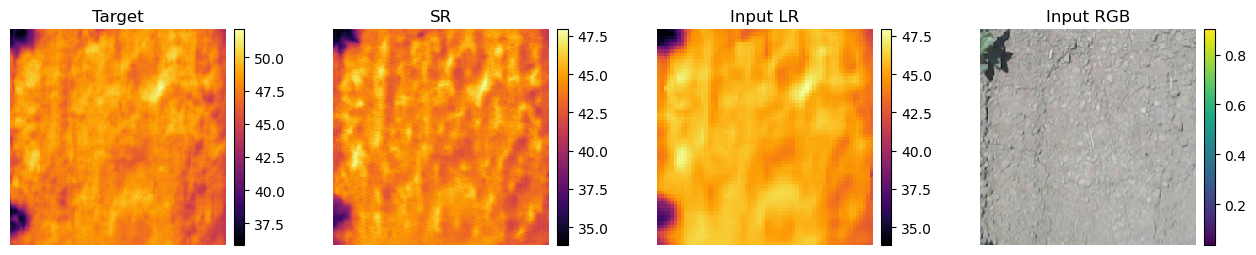

In [8]:
# Test Image
#rgb_img2 = move_tensor(rgb_img,-20,0)
#rgb_img2 = torch.FloatTensor(np.zeros((3,256,256)))
high_img = high_ir.squeeze()
lr_img = low_img.squeeze()
lr = low_img.unsqueeze(0).to(config.device, non_blocking=True)
rgb = rgb_img.unsqueeze(0).to(config.device, non_blocking=True)
rgb_img_disp = rgb_img.permute(1,2,0).cpu().detach().numpy()
print(thermal_info)
sr,_ = model(lr, rgb)
#print(model.stn.dtheta)
sr_img = sr.squeeze().cpu().detach().numpy()
lr_img = lr.squeeze().cpu().detach().numpy()
high_img = high_ir.squeeze().cpu().detach().numpy()
f, axarr = plt.subplots(1,4, figsize=(16,8))
high_img = calc_temp(high_img, thermal_info['hr'])
im0 = axarr[0].imshow(high_img, interpolation='none', cmap='inferno')
axarr[0].set_title("Target")
add_colorbar(im=im0,ax=axarr[0])
sr_img = calc_temp(sr_img, thermal_info['lr'])
im1 = axarr[1].imshow(sr_img, interpolation='none', cmap='inferno')
axarr[1].set_title("SR")
add_colorbar(im=im1,ax=axarr[1])
lr_img = calc_temp(lr_img, thermal_info['lr'])
im2 = axarr[2].imshow(lr_img, interpolation='none', cmap='inferno')
axarr[2].set_title("Input LR")
add_colorbar(im=im2,ax=axarr[2])
im3 = axarr[3].imshow(cv2.cvtColor(rgb_img_disp,cv2.COLOR_RGB2BGR),interpolation='none')
axarr[3].set_title("Input RGB")
add_colorbar(im=im3,ax=axarr[3])
axarr[3].axis("off")

plt.show()

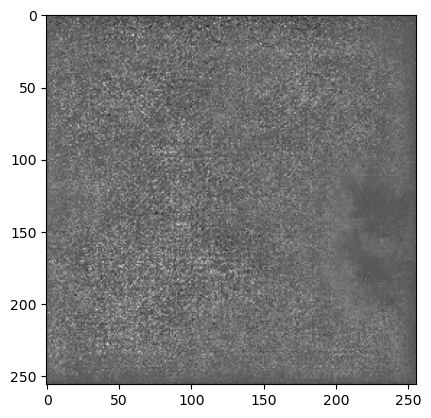

In [26]:
feature = debug[2].squeeze().cpu().detach().numpy()
plt.imshow(feature[2,:,:], cmap='gray')

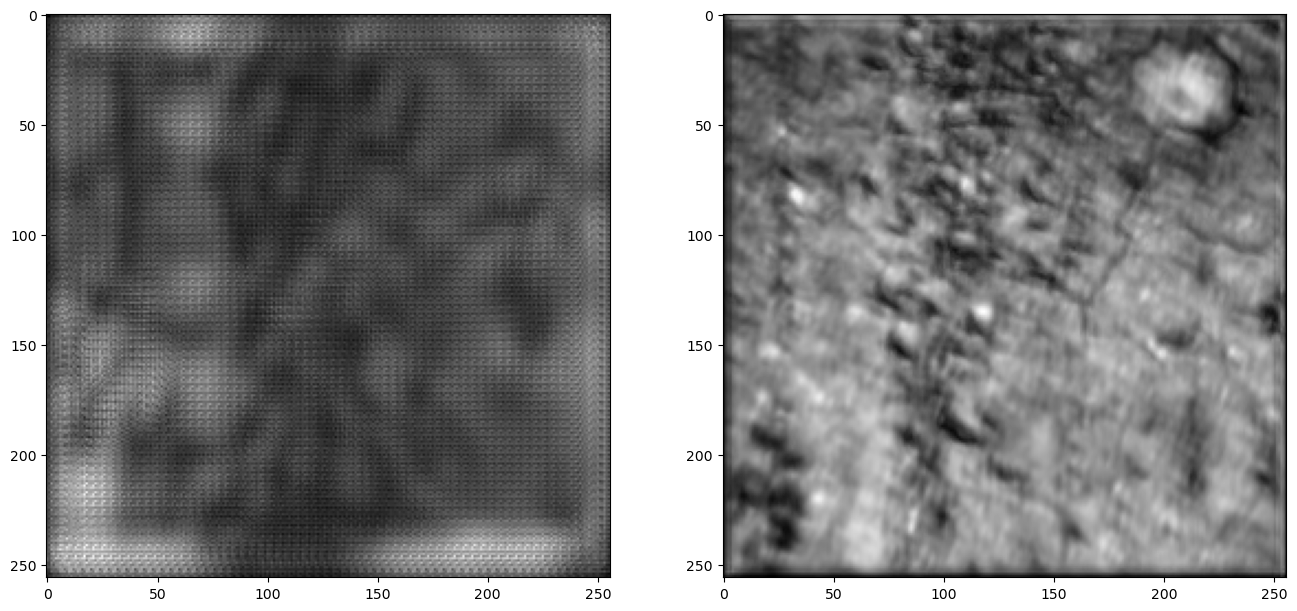

In [5]:


# Make 1x2 subplot
f, axarr = plt.subplots(1,2, figsize=(16,8))


feature = torch.mean(torch.abs(debug[0]),dim=1).squeeze().cpu().detach().numpy()
axarr[0].imshow(feature, cmap='gray')

feature = torch.mean(torch.abs(debug[1]),dim=1).squeeze().cpu().detach().numpy()
axarr[1].imshow(feature, cmap='gray')

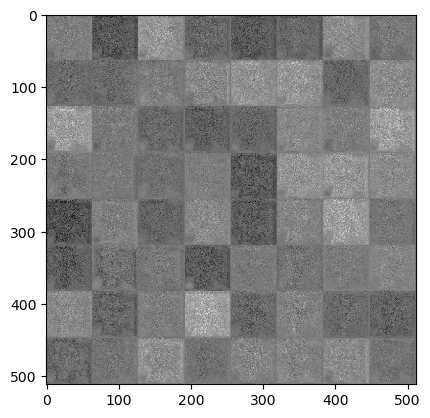

In [20]:
# Debug RGB Features
feature = debug[2].squeeze().cpu().detach().numpy()
# Create 8x8 image patch using (64,64,64) feature images
# 1. Get 64x64x64 feature image
feature_img = np.zeros(shape=(64*8,64*8))
for i in range(64):
    feature_img[64*(i//8):64*(i//8+1),64*(i%8):64*(i%8+1)] = cv2.resize(feature[i,:,:],dsize=(64,64))
plt.imshow(feature_img, interpolation='none', cmap='gray')


tensor([[ 1.0000e+00,  0.0000e+00, -1.6251e-02,  0.0000e+00,  1.0000e+00,
         -5.8746e-04]], device='cuda:0', grad_fn=<AddBackward0>)


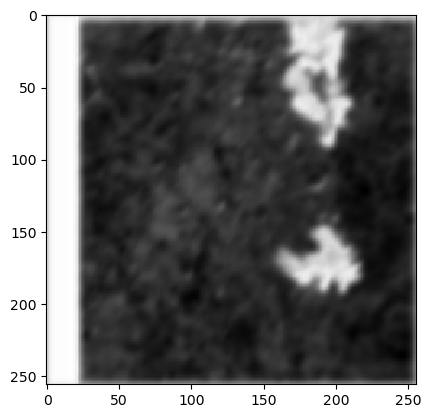

In [57]:

# Plot debug
print(model.stn.theta)
resampling_grid = F.affine_grid(
                    model.stn.theta.view(-1, 2, 3), debug[0].size())
warped_images = F.grid_sample(debug[0], resampling_grid, mode='bilinear', padding_mode='zeros', align_corners=False)
feature_img = warped_images.squeeze().cpu().detach().numpy()[0,:,:]
plt.imshow(feature_img, interpolation='none', cmap='gray')
# resampling_grid_img = resampling_grid.squeeze().cpu().detach().numpy()
# plt.imshow(resampling_grid_img[:,:,1], interpolation='none', cmap='gray')

{'lr': [24.51750000000004, 39.15750000000003], 'hr': [28.5, 40.410000000000025]}


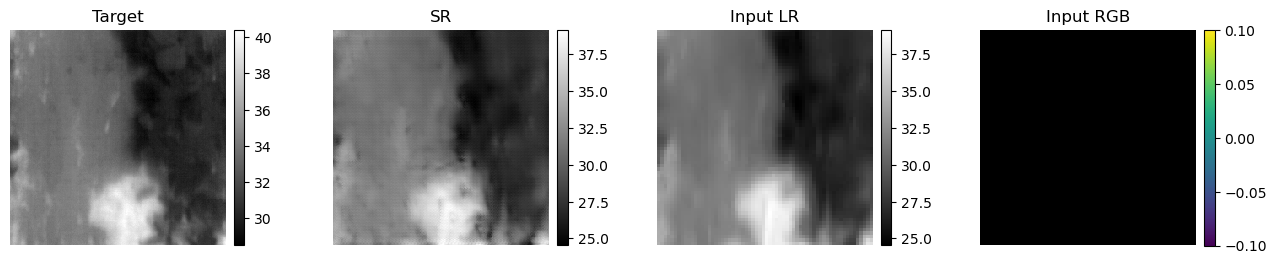

In [70]:
def create_dir(dir_):
    os.makedirs(dir_, exist_ok = True)
    
def process_dataset(dataroot, prefix, debug = False, write_img = True):
    # dataroot = "../../../datasets/GEMINI/2022-02-22-Greenhouse/"

    sr_dataroot_save = os.path.join(dataroot,"IR_ThermalRGB")
    create_dir(sr_dataroot_save)

    sample_dataset = ImageDataset(dataroot=dataroot,
                                image_size=96, upscale_factor=4, mode="train")

    for i in tqdm(range(len(sample_dataset.low_filenames))):
        (low_img, rgb_img, high_ir) = sample_dataset.getImage(i)

        low_img = torch.FloatTensor(low_img)[None, None,:, :]/255.0
        rgb_img = rgb_img[:, :, [2, 1, 0]] # swap channel from RGB to BGR
        rgb_img = torch.FloatTensor(rgb_img).permute(2,0,1).unsqueeze(0)/255.0

        high_ir = torch.FloatTensor(high_ir)[None, None,:, :]/255.0

        lr = low_img.to(config.device, non_blocking=True)
        rgb = rgb_img.to(config.device, non_blocking=True)
        high_ir = high_ir.to(config.device, non_blocking=True)

        sr = model(lr, rgb)

        sr_img = sr.squeeze().cpu().detach().numpy()
        lr_img = lr.squeeze().cpu().detach().numpy()
        high_img = high_ir.squeeze().cpu().detach().numpy()

        sr_name = '{prefix}_SR_480x640_{i:05d}.png'.format(prefix=prefix, i=i)

        if write_img:
            if 1:
                sr_img *= 255 # or any coefficient
                sr_img = sr_img.astype(np.uint8)
                cv2.imwrite(os.path.join(sr_dataroot_save,sr_name), sr_img)
            else:
                save_image(sr,os.path.join(sr_img,sr_name))

process_dataset(dataroot="/home/lion397/data/datasets/GEMINI/2022-04-05-Garbanzo/pairs_processed",prefix="220531_ThermalRGB",debug=False, write_img=True)

  0%|          | 0/170 [00:00<?, ?it/s]


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 160, 120, 3]

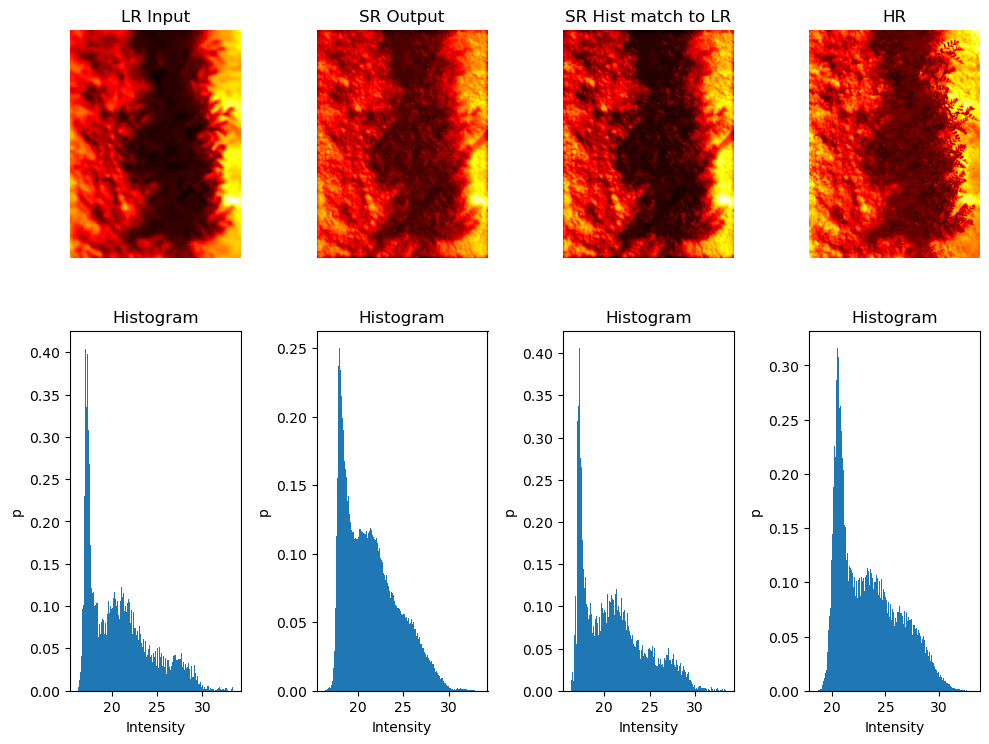

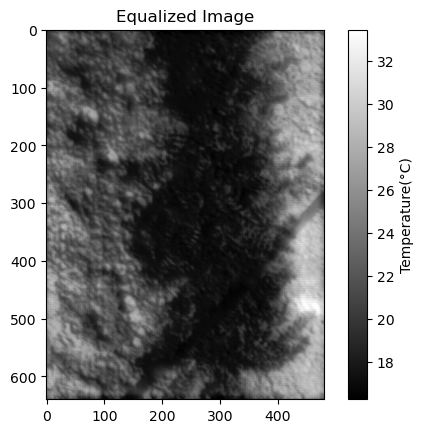

In [27]:
# Load the two input images
image1 = sr_img  # Load as grayscale
image2 = lr_img  # Load as grayscale


# Calculate the histogram of the first image
n_bins = 10000
#hist1, bins1 = np.histogram(image1.flatten(), n_bins,[0,1],density=True)
hist1, bins1 = np.histogram(image1.flatten(), n_bins, density=True)

# Calculate the cumulative distribution function (CDF) of the first image
cdf1 = hist1.cumsum()
cdf1_normalized = cdf1 / cdf1.max()

# Calculate the histogram of the second image
hist2, bins2 = np.histogram(image2.flatten(), n_bins,density=True)

# Calculate the cumulative distribution function (CDF) of the second image
cdf2 = hist2.cumsum()
cdf2_normalized = cdf2  / cdf2.max()

# Perform histogram equalization
cdf_mapping = np.interp(cdf1_normalized, cdf2_normalized, bins2[:-1])
# cdf_mapping = np.interp(cdf1, cdf2, bins2[:-1])
image1_equalized = cdf_mapping[np.round(cv2.normalize(image1, None, 0, 1, cv2.NORM_MINMAX).astype(np.float64) * (n_bins-1)).astype('uint32')]

# Display the original and equalized images
fig, ax = plt.subplots(2, 4, figsize=(10, 8))
ax[0, 0].imshow(image2, cmap='hot')
ax[0, 0].set_title('LR Input')
ax[0, 0].axis('off')
ax[0, 1].imshow(image1, cmap='hot')
ax[0, 1].set_title('SR Output')
ax[0, 1].axis('off')
#ax[1, 0].plot(bins2[:-1],hist2,color='r')
ax[1, 0].hist(image2.flatten(), 256, density=True)
#ax[1, 0].set_title('LR Input')
ax[1, 0].set_title('Histogram')
ax[1, 0].set_xlabel("Intensity")
ax[1, 0].set_ylabel("p")
ax[1, 1].hist(image1.flatten(), 256, density=True)
#ax[1, 1].set_title('SR Output')
ax[1, 1].set_title('Histogram')
ax[1, 1].set_xlabel("Intensity")
ax[1, 1].set_ylabel("p")

ax[0, 2].imshow(image1_equalized, cmap='hot')
ax[0, 2].axis('off')
ax[0, 2].set_title('SR Hist match to LR')

ax[1, 2].set_ylabel("p")
ax[1, 2].hist(image1_equalized.flatten(), 256, density=True)
ax[1, 2].set_title('Histogram')
ax[1, 2].set_xlabel("Intensity")
ax[1, 2].set_ylabel("p")

ax[0, 3].imshow(high_img, cmap='hot')
ax[0, 3].axis('off')
ax[0, 3].set_title('HR')

ax[1, 3].set_ylabel("p")
ax[1, 3].hist(high_img.flatten(), 256, density=True)
ax[1, 3].set_title('Histogram')
ax[1, 3].set_xlabel("Intensity")
ax[1, 3].set_ylabel("p")



plt.tight_layout()
plt.show()

# Display the equalized image
plt.imshow(image1_equalized,cmap="gray")
plt.title('Equalized Image')
colorbar = plt.colorbar()
colorbar.set_label('Temperature(°C)')

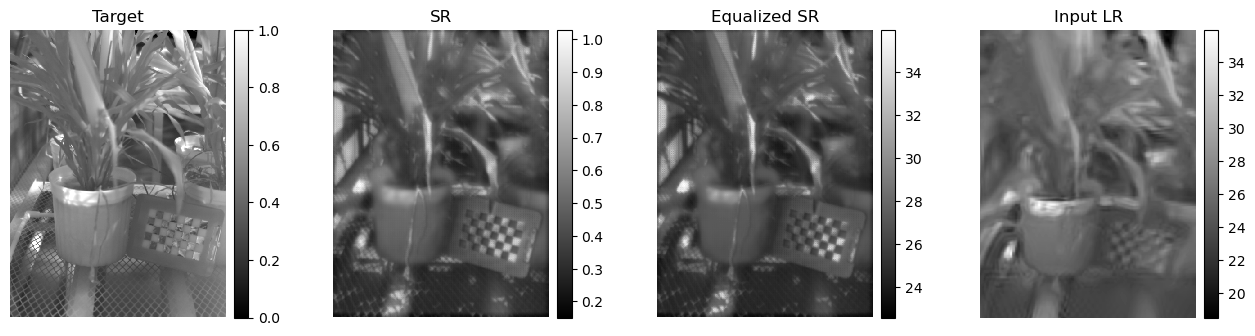

In [57]:
f, axarr = plt.subplots(1,4, figsize=(16,8))
im0 = axarr[0].imshow(high_img, interpolation='none', cmap='gray')
axarr[0].set_title("Target")
add_colorbar(im=im0,ax=axarr[0])
im1 = axarr[1].imshow(sr_img, interpolation='none', cmap='gray')
axarr[1].set_title("SR")
add_colorbar(im=im1,ax=axarr[1])
im2 = axarr[2].imshow(image1_equalized, interpolation='none', cmap='gray')
axarr[2].set_title("Equalized SR")
add_colorbar(im=im2,ax=axarr[2])
#im3 = axarr[3].imshow(lr_img, interpolation='none', cmap='gray',vmin=0, vmax=1.0)
im3 = axarr[3].imshow(image2, interpolation='none', cmap='gray')
axarr[3].set_title("Input LR")
add_colorbar(im=im3,ax=axarr[3])

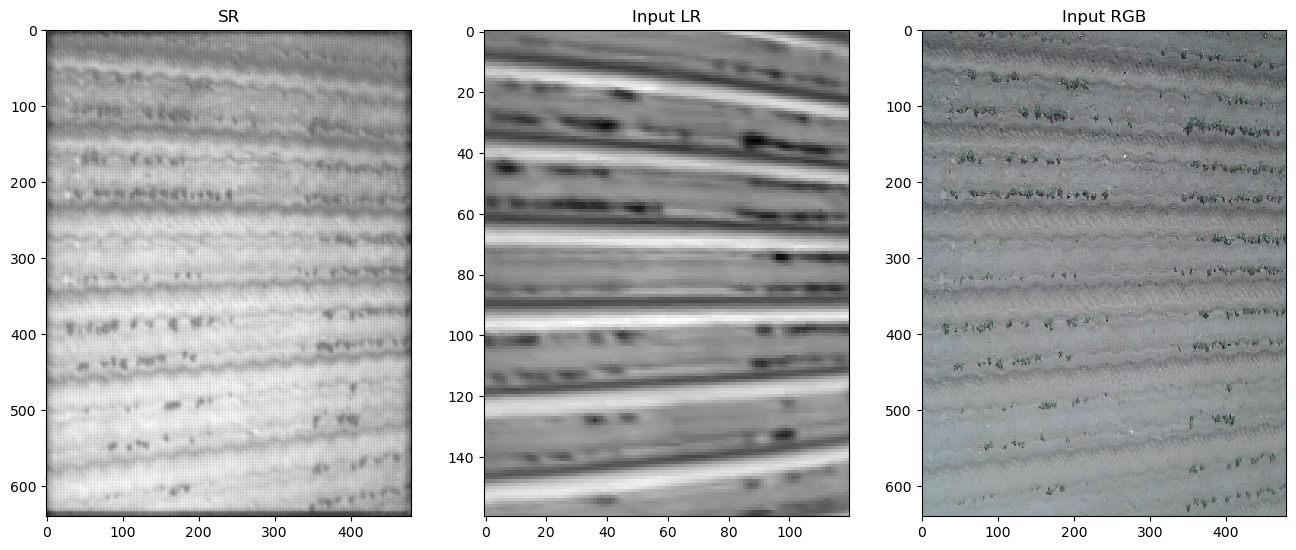

In [6]:
from tifffile import imsave, imread
# Test Image
rgb_img = cv2.imread("/home/GEMINI/Dataset/Davis_Legumes/2022-06-20/Drone/iPhone/backup/flir_processed/220620_IMG_01570_RGB.jpg")
rgb_img = cv2.resize(rgb_img,dsize=(480,640))
low_img = imread("/home/GEMINI/Dataset/Davis_Legumes/2022-06-20/Drone/iPhone/flir_processed/1_IR/220620_IMG_01570_IR.tiff") / 1000
low_img = cv2.resize(low_img, dsize=(rgb_img.shape[1]//4,rgb_img.shape[0]//4))

if 0:
    crop_bbox = [0,0,200,200]
    low_img = low_img[crop_bbox[0]//4:crop_bbox[2]//4,crop_bbox[1]//4:crop_bbox[3]//4]
    rgb_img = rgb_img[crop_bbox[0]:crop_bbox[2],crop_bbox[1]:crop_bbox[3]]
    high_ir = high_ir[crop_bbox[0]:crop_bbox[2],crop_bbox[1]:crop_bbox[3]]

rgb_img_disp = rgb_img
low_img = torch.FloatTensor(low_img)[None, None,:, :]/255.0
rgb_img = rgb_img[:, :, [2, 1, 0]] # swap channel from RGB to BGR
rgb_img = torch.FloatTensor(rgb_img).permute(2,0,1).unsqueeze(0)/255.0
#high_ir = torch.FloatTensor(high_ir)[None, None,:, :]/255.0
lr = low_img.to(config.device, non_blocking=True)
rgb = rgb_img.to(config.device, non_blocking=True)
#high_ir = high_ir.to(config.device, non_blocking=True)
sr = model(lr, rgb)
sr_img = sr.squeeze().cpu().detach().numpy()
lr_img = lr.squeeze().cpu().detach().numpy()

# plt.imshow(sr_img,cmap='gray')
f, axarr = plt.subplots(1,3, figsize=(16,8))
#plt.colorbar(im0, ax=axarr[0])
im1 = axarr[0].imshow(sr_img, interpolation='none', cmap='gray')
#im1 = axarr[1].imshow(sr_img, interpolation='none', cmap='gray')
axarr[0].set_title("SR")
#plt.colorbar(im1, ax=axarr[1])
im2 = axarr[1].imshow(lr_img, interpolation='none', cmap='gray')
#im2 = axarr[2].imshow(lr_img, interpolation='none', cmap='gray')
axarr[1].set_title("Input LR")
#plt.colorbar(im2, ax=axarr[2])
im3 = axarr[2].imshow(cv2.cvtColor(rgb_img_disp,cv2.COLOR_RGB2BGR),interpolation='none')
axarr[2].set_title("Input RGB")
#plt.colorbar(im3, ax=axarr[3])

plt.show()

In [9]:
def matchTemplateTorchCore(img_tensor, template_tensor):
    # Add padding to the image
    x_offset = img_tensor.shape[2]//2
    y_offset = img_tensor.shape[3]//2
    img_tensor_padded = torch.nn.functional.pad(img_tensor, 
                                    (x_offset, x_offset, y_offset, y_offset), mode='replicate')

    result1 = torch.nn.functional.conv2d(img_tensor_padded, template_tensor, bias=None, stride=1, padding=0)
    result2 = torch.sqrt(torch.sum(template_tensor**2) * torch.nn.functional.conv2d(img_tensor**2, torch.ones_like(template_tensor), bias=None, stride=1, padding=0))

    result = result1/result2
    # Find max location and value from rresultesult1 matric
    result_max = torch.max(result)
    result_max_loc = torch.argmax(result)
    result_max_loc_x = result_max_loc % result.shape[2] 
    result_max_loc_y = result_max_loc // result.shape[3] 
    
    print(result_max_loc, result_max_loc_x, result_max_loc_y, result_max)
    
    # Clamp value within image size
    result_max_loc_x = torch.clamp(result_max_loc_x, 0, img_tensor.shape[2])
    result_max_loc_y = torch.clamp(result_max_loc_y, 0, img_tensor.shape[3])


    # Make theta matrix from max location
    theta = torch.tensor([[1., 0., result_max_loc_x / img_tensor.shape[2]],
                            [0., 1., result_max_loc_y / img_tensor.shape[3]]] )
    theta = theta.unsqueeze(0).repeat(img_tensor.shape[0],1,1)

    return theta, img_tensor_padded

tensor(30583) tensor(0) tensor(119) tensor(1.0302)


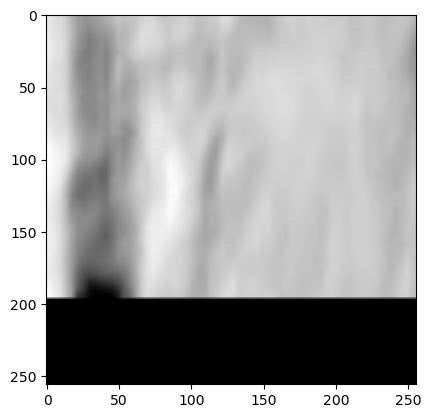

In [10]:
hr = high_ir.unsqueeze(0).to("cpu", non_blocking=True)
#lr = lr_img.unsqueeze(0).to(config.device, non_blocking=True)
# Resize lr
lr = F.interpolate(lr, size=hr.shape[2:], mode='bilinear', align_corners=False).to("cpu", non_blocking=True)
theta, img_tensor_padded = matchTemplateTorchCore(hr, lr)
resampling_grid = F.affine_grid(theta.view(-1, 2, 3), lr.size())
lr_aligned = F.grid_sample(lr, resampling_grid, mode='bilinear', padding_mode='zeros', align_corners=False) # 'zeros', 'border', or 'reflection'
plt.imshow(lr_aligned.squeeze().cpu().detach().numpy(), cmap='gray')

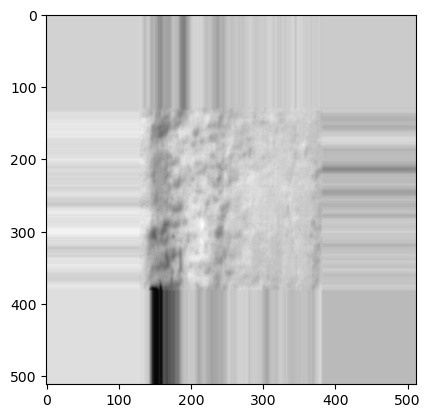

In [11]:
plt.imshow(img_tensor_padded.squeeze().cpu().detach().numpy(), cmap='gray')

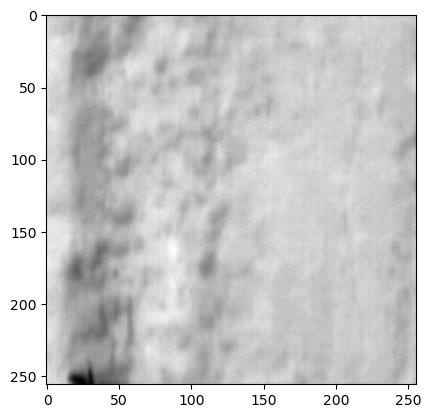

In [12]:
plt.imshow(hr.squeeze().cpu().detach().numpy(), cmap='gray')